In [22]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy.random as nprm
import datetime 

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash


---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
~/anaconda3/lib/python3.9/site-packages/dash/_callback.py in add_context(
    *args=({'xaxis.range[0]': '1976-06-10 18:28:40.354', 'xaxis.range[1]': '1976-06-10 18:28:40.354'},),
    **kwargs={}
)
    478             try:
--> 479                 jsonResponse = to_json(response)
        jsonResponse = undefined
        global to_json = <function to_json at 0x7f845a127430>
        response = {'multi': True, 'response': defaultdict(<class 'dict'>, {'fig': {'figure': <Figure size 576x576 with 4 Axes>}})}
    480             except TypeError:

~/anaconda3/lib/python3.9/site-packages/dash/_utils.py in to_json(
    value={'multi': True, 'response': defaultdict(<class 'dict'>, {'fig': {'figure': <Figure size 576x576 with 4 Axes>}})}
)
     21 
---> 22     return to_json_plotly(value)
        to_json_plotly = <function to_json_plotly at 0x7f8453

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
~/anaconda3/lib/python3.9/site-packages/dash/_callback.py in add_context(
    *args=({'xaxis.autorange': True, 'xaxis.showspikes': False},),
    **kwargs={}
)
    478             try:
--> 479                 jsonResponse = to_json(response)
        jsonResponse = undefined
        global to_json = <function to_json at 0x7f845a127430>
        response = {'multi': True, 'response': defaultdict(<class 'dict'>, {'fig': {'figure': <Figure size 576x576 with 4 Axes>}})}
    480             except TypeError:

~/anaconda3/lib/python3.9/site-packages/dash/_utils.py in to_json(
    value={'multi': True, 'response': defaultdict(<class 'dict'>, {'fig': {'figure': <Figure size 576x576 with 4 Axes>}})}
)
     21 
---> 22     return to_json_plotly(value)
        to_json_plotly = <function to_json_plotly at 0x7f8453171dc0>
        value = {'multi': True

# Investing in SP500: how well did it work in the past?

For most investors, a wise way to invest is through an index fund. The simplest strategy is to drip-feed a fixed amount each month regardless of market conditions.

The major complexity of this strategy is psychological: to sleep well at night following it requires a strong belief in its effectiveness. This notebook shows some analysis on the performance of following the SP500 in the past. 

Obviously, past performance does not predict the future performance of a strategy, as market conditions are always changing and unique. The objective of these analyses is rather to understand some of the empirical evidence behind the strategy.

First, we read a `csv` file with the historic data of the SP500 index. This index contains a selection of 500 large US companies, curated by Standard & Poors's. In principle, we would like to diversify beyond a single country, so globally diversified indexes such as Vanguard FTSE All-World are often recommended to minimize the risk associated with a single country. However, SP500 has been around much longer, so it is more useful for our analysis.

We convert the `Date` column into a `datetime` format and then we extract new columns for each day/month/year, and a extra columns which combines year and month. 

In [2]:
df = pd.read_csv('data/SP500.csv')
df['Date'] =  pd.to_datetime(df['Date'])
df['year'] = df['Date'].map(lambda x: x.year)
df['month'] = df['Date'].map(lambda x: x.month)
df['day'] = df['Date'].map(lambda x: x.day)
df['year-month'] = df['Date'].map(lambda x: '{}-{}'.format(x.year, x.month) )


Anyway, that is too much data, we have daily variations from before 1928, so instead, we will filter the data to only include the first open day for each month. In the new dataframe the value for `Close` column  will correspond to the closing value on the last day of the month.

In [3]:
df1 = df.groupby('year-month').nth(0)
df1.sort_values(by=['Date'], inplace=True)
df1 = df.groupby('year-month').agg({ 'High': max,'Low': min})
df1['Open'] = df.groupby('year-month').nth(0)['Open']
df1['Close'] = df.groupby('year-month').nth(-1)['Close']
df1['Date'] = df.groupby('year-month').nth(0)['Date']
display(df1)


,High,Low,Open,Close,Date
year-month,,,,,
1927-12,17.660000,17.660000,17.660000,17.660000,1927-12-30
1928-1,17.760000,17.260000,17.760000,17.570000,1928-01-03
1928-10,22.000000,21.110001,21.360001,21.680000,1928-10-01
1928-11,24.280001,21.950001,21.990000,24.280001,1928-11-01
1928-12,24.350000,22.309999,23.850000,24.350000,1928-12-03
...,...,...,...,...,...
2020-6,3233.129883,2965.659912,3038.780029,3100.290039,2020-06-01
2020-7,3279.989990,3101.169922,3105.919922,3271.120117,2020-07-01
2020-8,3514.770020,3284.530029,3288.260010,3500.310059,2020-08-03


Let's plot the historical data month to month.
(I got a code from [Stackoverflow](https://stackoverflow.com/questions/72670037/dynamically-adjusting-y-axis-of-a-graph-produced-by-plotly-graph-objects/72673666) to dynamically adjust the y-axis ) 

In [4]:
fig = go.Figure(data=[go.Candlestick(x=df1['Date'],
                open=df1['Open'],
                high=df1['High'],
                low=df1['Low'],
                close=df1['Close'])])


# Build App
app = JupyterDash(__name__)

app.layout = dash.html.Div(
    [
        dash.dcc.Graph(
            id="fig",
            figure=fig,
        ),
    ]
)


@app.callback(
    Output("fig", "figure"),
    Input("fig", "relayoutData"),
)
def scaleYaxis(rng):
    if rng and "xaxis.range" in rng.keys():
        try:
            d = df1.loc[
                rng["xaxis.range"][0] : rng["xaxis.range"][1],
                ["High", "Low", "Open", "Close"],
            ]
            if len(d) > 0:
                fig["layout"]["yaxis"]["range"] = [d.min().min(), d.max().max()]
        except KeyError:
            pass
        finally:
            fig["layout"]["xaxis"]["range"] = rng["xaxis.range"]

    return fig


app.run_server(mode="inline")

## Returns of a lump sum investment
First, we analyze the return of investing one dollar and selling after a certain number of years, ignoring the cost of commissions, and without discounting inflation. We make statistics by varying the starting point of the investment.

In [14]:
df2 = df1
# if you want to restrict the period analyzed you can instead use df2 = df1[df1['Date']>'1980-01-01']
data_months = df2.shape[0]

df_out = pd.DataFrame()

for years in [1, 2,5,10,20]:
    saving_months = 12 * years
    gains = []
    for i in range(0, data_months-saving_months):
        p_open = df2['Open'].iloc[i]
        p_close = df2['Close'].iloc[i + saving_months - 1]
        gains.append(p_close/p_open ) 
    dfo = pd.DataFrame({'gains':gains})
    dfo['years'] = years                   
    df_out = pd.concat([ df_out,  dfo ] )
df_out.reset_index(inplace=True)    

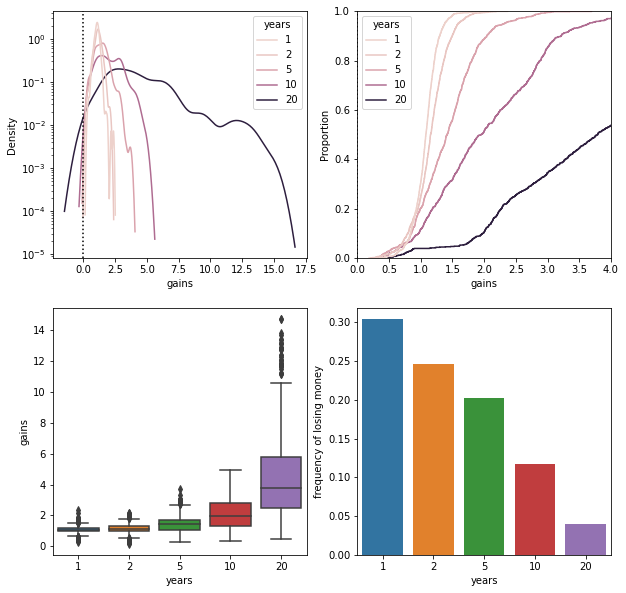

In [18]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.reshape(4)
sns.kdeplot(data=df_out,x='gains',hue='years',
             common_norm=False, ax=axs[0])
axs[0].axvline(0,ls=':',color='k')
#axs[0].set_xscale('log')
axs[0].set_yscale('log')

sns.ecdfplot(data=df_out,x='gains',hue='years',ax=axs[1])
axs[1].set_xlim(0,4)
axs[1].axvline(0,ls=':',color='k')


sns.boxplot(data=df_out,y='gains',x='years',ax=axs[2])

dfloss = df_out.groupby('years').agg({'gains':lambda x: x[x<1].size/x.size})
sns.barplot(x=dfloss.index,y=dfloss['gains'], ax=axs[3])
axs[3].set_ylabel('frequency of losing money')
plt.show()

## Return of drip-feeding investment
Now, let's consider the return obtained by investing in a more realistic way. Putting a fixed amount at the beginning of each month for a certain number of years. Again, we are ignoring the cost of commissions and we also do not discount the effect of inflation.

In [20]:
df2 = df1 #[df1['Date']>'1980-01-01']
data_months = df2.shape[0]

df_drip = pd.DataFrame()

for years in [1, 2, 5, 10, 20, 40]:
    saving_months = 12 * years
    gains = []
    for i in range(0, data_months-saving_months):
        val_in = 0
        val = 0
        for j in range(0, saving_months): 
            val_in += 1
            val += 1
            p_open = df2['Open'].iloc[i+j]
            p_close = df2['Close'].iloc[i+j]
            val *= p_close/p_open 
            
        gains.append(val/val_in)
  
    dfo = pd.DataFrame({'gains':gains})
    dfo['years'] = years                   
    df_drip = pd.concat([ df_drip,  dfo ] )
df_drip.reset_index(inplace=True)  

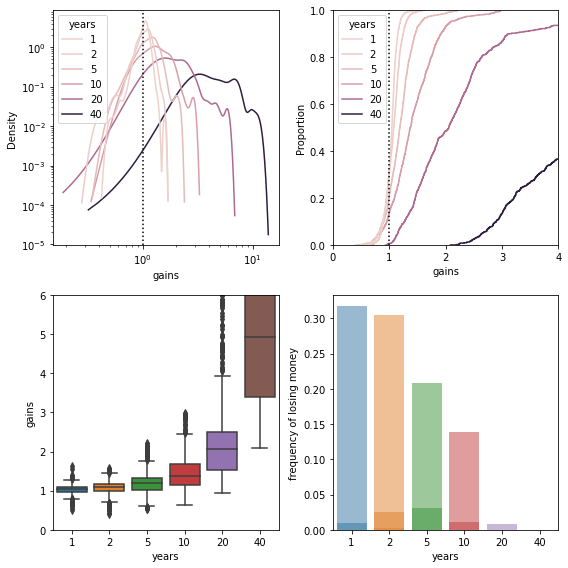

In [21]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.reshape(4)
sns.kdeplot(data=df_drip,x='gains',hue='years',
             common_norm=False, ax=axs[0])
axs[0].set_xscale('log')
axs[0].set_yscale('log')

sns.ecdfplot(data=df_drip,x='gains',hue='years',ax=axs[1])
axs[0].axvline(1,ls=':',color='k')
axs[1].axvline(1,ls=':',color='k')
axs[1].set_xlim(0,4)

sns.boxplot(data=df_drip,y='gains',x='years',ax=axs[2])
axs[2].set_ylim(0,6)

for lim in [1,0.75,0.5]:
    dfloss = df_drip.groupby('years').agg({'gains':lambda x: x[x<lim].size/x.size})
    sns.barplot(x=dfloss.index,y=dfloss['gains'], ax=axs[3], alpha=0.5)
    axs[3].set_ylabel('frequency of losing money')

plt.tight_layout()
plt.show()

Notice that now at 20 years the risk of losing money becomes zero.

# Coming next: how timing the market is a bad idea

*Time in the market beats timing the market* is a known adagio